In [1]:
import numpy as np

In [2]:
DATASET_TOP_LEFT_GPS = np.array((12.86308254761559, 77.5151947517078))
DATASET_TOP_RIGHT_GPS = np.array((12.863010715187013, 77.52267023737696))
DATASET_BOT_LEFT_GPS = np.array((12.859008245256549, 77.5151541499705))
DATASET_BOT_RIGHT_GPS = np.array((12.858936436333265, 77.52262951527761))

DATASET_CORNER_GPS_COORDS = DATASET_TOP_LEFT_GPS, DATASET_TOP_RIGHT_GPS, DATASET_BOT_LEFT_GPS, DATASET_BOT_RIGHT_GPS

DATASET_WIDTH = 14180
DATASET_HEIGHT = 7877

## Coordinate transformation functions

In [3]:
# Pixel to GPS transform for a single image. width and height are the width and height of image
def get_pixel_to_gps_transform(corner_gps_coords, width, height):
    top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = corner_gps_coords
    right_vec = (top_right_gps - top_left_gps)/width
    bot_vec = (bot_left_gps - top_left_gps)/height

    transformation = np.array([[right_vec[0], bot_vec[0]], [right_vec[1], bot_vec[1]]])
    
    def transform(pixel):
        return transformation @ pixel + top_left_gps
    
    return transform

In [4]:
DATASET_PIXEL_TO_GPS_TRANSFORM = get_pixel_to_gps_transform(DATASET_CORNER_GPS_COORDS, DATASET_WIDTH, DATASET_HEIGHT)

In [5]:
import math

# CCW rotation
def rotate_point_about_origin(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    x_new = x * math.cos(radians) - y * math.sin(radians)
    y_new = x * math.sin(radians) + y * math.cos(radians)

    return x_new, y_new


def rotate_pixel_about_origin(xy, radians):
    return rotate_point_about_origin(xy, -radians)

def rotate_pixel_about_center(xy, center, radians):
    vector = np.array(xy) - np.array(center)
    return rotate_pixel_about_origin(vector, radians)

def transform_sample_pixel_coords_to_dataset_pixel_coords(xy, sample_center, radians, sample_dim):
    # Sample pixel coordinate system has (0,0) at the top left of the sample image
    sample_center_in_sample_pixel_coords = np.array((sample_dim[1]/2, sample_dim[0]/2))
    rotated_coords = rotate_pixel_about_center(xy, sample_center_in_sample_pixel_coords, radians)
    coords = rotated_coords + sample_center
    return coords

# sample_center is the sample center coordinates in the dataset pixel coordinate system    
def transform_sample_pixel_coords_to_gps_coords(xy, sample_center, radians, sample_dim):
    dataset_pixel_coords = transform_sample_pixel_coords_to_dataset_pixel_coords(xy, sample_center, radians, sample_dim)
    return DATASET_PIXEL_TO_GPS_TRANSFORM(dataset_pixel_coords)
    
# center is the center coordinates (np array) of the sample image in the dataset pixel coordinate system
# radians is the angle that the sample image coordinate system is rotated relative to the dataset
    # coordinate system (CCW)
# sample_dim is (height, width)
def get_corner_gps_coords_of_sample_img(center, radians, sample_dim):
    height = sample_dim[0]
    width = sample_dim[1]
    
    top_left_pixel = np.array((0,0))
    top_right_pixel = np.array((width,0))
    bot_left_pixel = np.array((0,height))
    bot_right_pixel = np.array((width,height))
    
    top_left_gps = transform_sample_pixel_coords_to_gps_coords(top_left_pixel, center, radians, sample_dim)
    top_right_gps = transform_sample_pixel_coords_to_gps_coords(top_right_pixel, center, radians, sample_dim)
    bot_left_gps = transform_sample_pixel_coords_to_gps_coords(bot_left_pixel, center, radians, sample_dim)
    bot_right_gps = transform_sample_pixel_coords_to_gps_coords(bot_right_pixel, center, radians, sample_dim)
    return (top_left_gps, top_right_gps, bot_left_gps, bot_right_gps)


## Layers

In [6]:
test_gcps_pixels = np.array([(8000, 3000), (9000, 3000), (9000, 4000), (11000, 5000)])

In [7]:
import mmcv

mmcv.collect_env()

from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector
from mmrotate.models import build_detector

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

import grpc
# import messaging_pb2
# import messaging_pb2_grpc

import os
import sys
import random
import cv2
import time

import torch

# (height, width)
OUTPUT_DIM = (1000,1000)

class ImageProcessingLayer:
    def __init__(
        self,
        mock=True,
        mock_image_path=None,
        mock_num_samples=10,
        mock_wait_time=1,
    ):
        self.mock = mock

        if not mock:
            return

        self.mock_wait_time = mock_wait_time

        if mock_image_path is None:
            mock_image_path = "data/demo.jpg"

        self._mock_img_full = np.asarray(Image.open(mock_image_path))
        self._output_dim = OUTPUT_DIM
        diag_len = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)
#         self._gcps_pixels = self._generate_random_gcps(
#             self._mock_img_full, mock_num_samples, padding=(diag_len, diag_len)
#         )
        self._gcps_pixels = test_gcps_pixels
        
        # maybe convert from pixels to lat/lon here

        self._path_pixels = self._build_path_pixels(self._gcps_pixels)

    def _generate_random_gcps(self, img, num_samples, padding=(0, 0)):
        return np.random.randint(
            padding,
            high=(img.shape[1] - padding[0], img.shape[0] - padding[1]),
            size=(num_samples, 2),
        )

    def _build_path_pixels(self, gcps):
        STEP_SIZE = 400
        
        delta = np.diff(gcps, axis=0)
        directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
        angles = -np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
        delta_angles = np.append(np.diff(angles), 0)

        path = []

        for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
            steps = np.linalg.norm(t2 - t1) / STEP_SIZE
            line = np.linspace(t1, t2, steps.astype("uint32"), dtype="uint32")
            path.extend([np.array([x, y, angle]) for x, y in line])

            if delta_angle == 0:
                continue

            if len(line) == 0:
                continue

            interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
            path.extend(
                [
                    np.array([line[-1][0], line[-1][1], theta])
                    for theta in interpolated_angles
                ]
            )

        return path

    def _next_image(self):
        if self.mock_wait_time > 0:
            time.sleep(self.mock_wait_time)

        sample_diag = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)

        for x, y, theta in self._path_pixels:
            sample = self._crop_around(
                self._mock_img_full, (y, x), (sample_diag, sample_diag)
            )
            rotated_img = self._center_crop(
                rotate(sample, -theta, reshape=False), self._output_dim
            )
          
            theta_radians = theta / 180 * math.pi
            
            center = np.array((x, y))
            
            corner_gps_coords = get_corner_gps_coords_of_sample_img(center, theta_radians, self._output_dim)
            
            yield rotated_img, corner_gps_coords

    def _crop_around(self, img, center, dim):
        dim = np.array(dim).astype("uint32")
        x = int(center[1] - dim[1] // 2)
        y = int(center[0] - dim[0] // 2)
        return img[y : y + dim[0], x : x + dim[1]]

    def _center_crop(self, img, dim):
        return img[
            img.shape[0] // 2 - dim[0] // 2 : img.shape[0] // 2 + dim[0] // 2,
            img.shape[1] // 2 - dim[1] // 2 : img.shape[1] // 2 + dim[1] // 2,
        ]

    def run(self, img=None):
        if not self.mock:
            assert img is not None, "Image cannot be None"
            return img

        return self._next_image()


class ObjectDetectionLayer:
    def __init__(
        self, config_file=None, checkpoint_file=None, device=torch.device('cpu'), min_confidence=0.3
    ):
        if config_file is None:
            config_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90.py"
        if checkpoint_file is None:
            checkpoint_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth"

        self.config_file = config_file
        self.checkpoint_file = checkpoint_file
        self.device = device

        self.model = self._load_model()
        self.min_confidence = min_confidence

    def _load_model(self):
        config = mmcv.Config.fromfile(self.config_file)
        config.model.pretrained = None

        model = build_detector(config.model)
        checkpoint = load_checkpoint(
            model, self.checkpoint_file, map_location=self.device
        )

        model.CLASSES = checkpoint["meta"]["CLASSES"]
        model.cfg = config
        model.to(self.device)
        model = model.eval()

        return model

    def _get_bboxes_pixels(self, img):
        vehicle_classes = [
            i for i, c in enumerate(self.model.CLASSES) if "vehicle" in c
        ]

        inference = inference_detector(self.model, img)
        bboxes = [inference[index] for index in vehicle_classes]

        bboxes = np.concatenate(bboxes, axis=0)
        bboxes = bboxes[bboxes[:, 5] > self.min_confidence]

        # the bboxes are in a weird polygonal format, so we convert them to rectangles
        rect_bboxes = (
            np.array(
                [
                    bboxes[:, 1] - bboxes[:, 2] // 2,
                    bboxes[:, 1] + bboxes[:, 2] // 2,
                    bboxes[:, 0] - bboxes[:, 2] // 2,
                    bboxes[:, 0] + bboxes[:, 3],
                    100 * bboxes[:, -1],  # confidence score
                ]
            )
            .astype(int)
            .T
        )

        # follows the format of x0, x1, y0, y1, confidence
        return rect_bboxes

    def run(self, img):
        result = self._get_bboxes_pixels(img)

        # convert pixels to lat/lon here
        return result


class MavlinkInterfaceLayer:
    def __init__(self, protos_path="pipelined_grpc/protos"):
        self.protos_path = protos_path
        self.channel = grpc.insecure_channel("localhost:50051")
        pass

    def run(self, bboxes):
        if len(bboxes) == 0:
            return

        print(bboxes)

/home/matt/RT-Flight/testing/RT-env/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [8]:
# theta_radians = angle / 180 * math.pi
# bb = transform_rotated_sample_pixel_coords_to_gps_coords(np.array((1500,1500)), np.array(center), theta_radians, OUTPUT_DIM)

## Run the pipeline

/home/matt/RT-Flight/testing/RT-env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (111695860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/matt/RT-Flight/testing/RT-env/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
showing rotated image


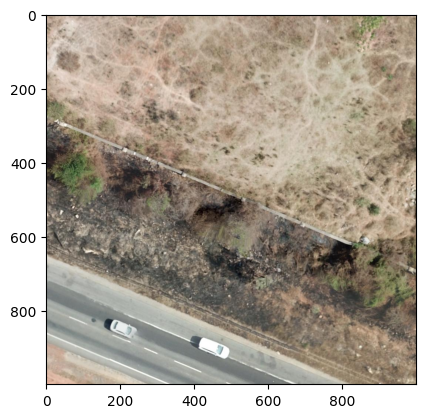

/home/matt/RT-Flight/testing/RT-env/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


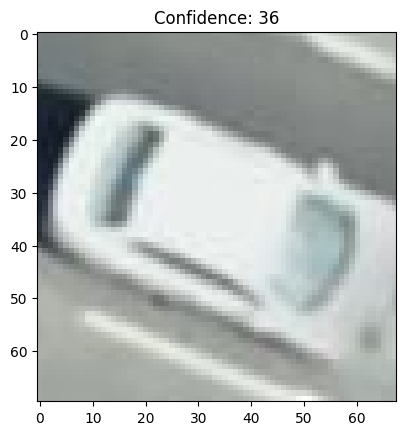

showing rotated image


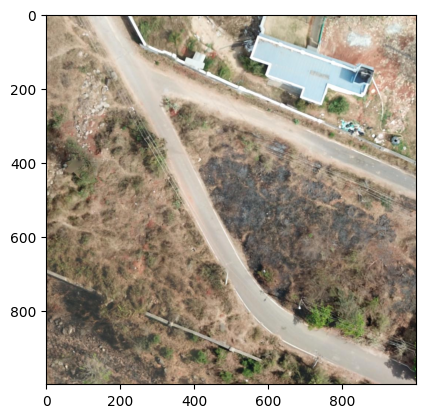

showing rotated image


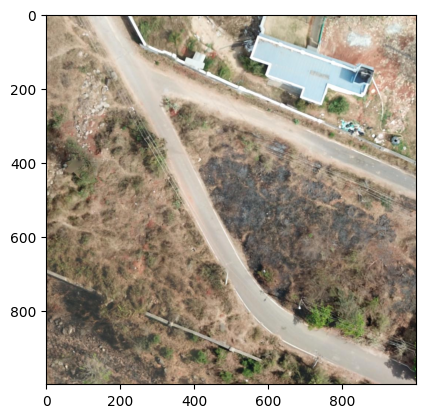

showing rotated image


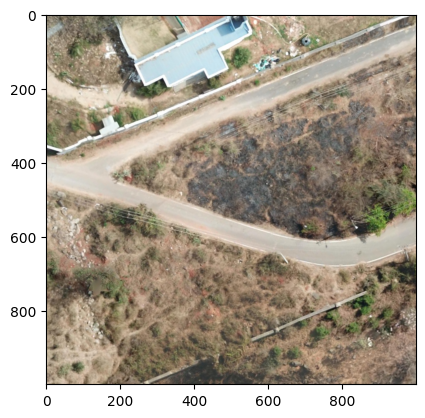

showing rotated image


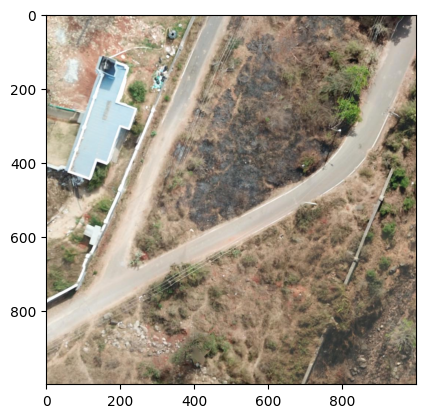

showing rotated image


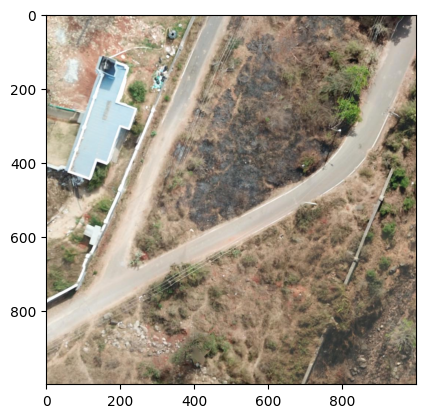

showing rotated image


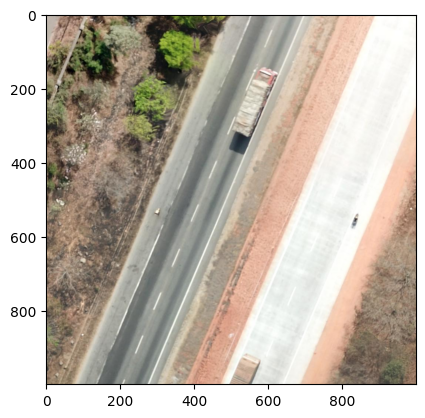

showing rotated image


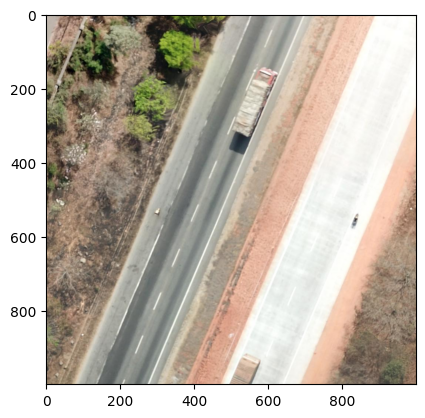

showing rotated image


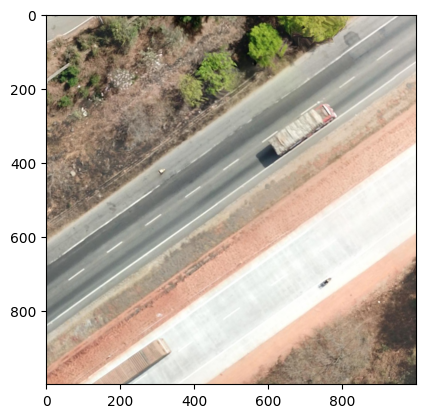

showing rotated image


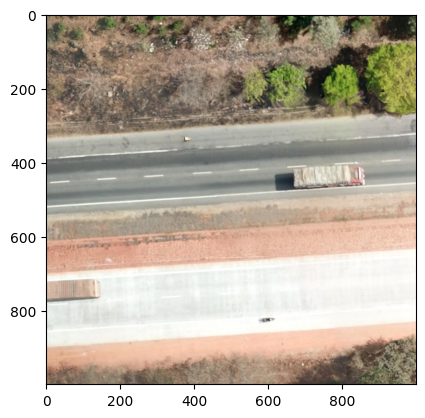

showing rotated image


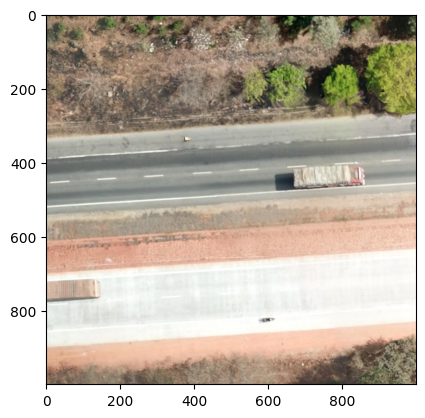

showing rotated image


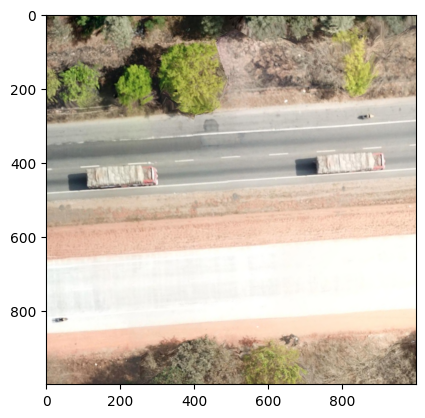

showing rotated image


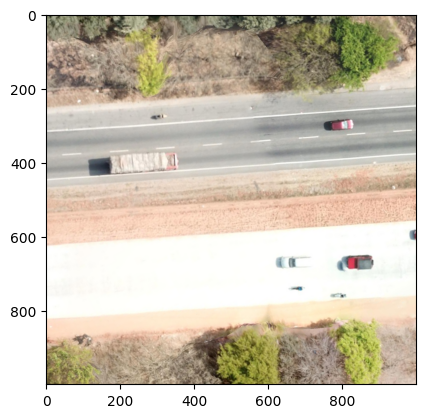

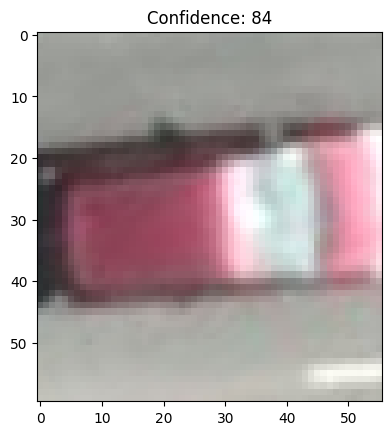

showing rotated image


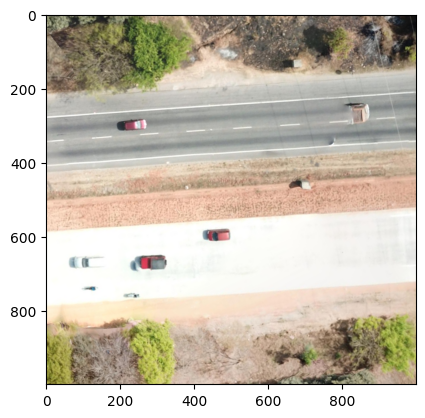

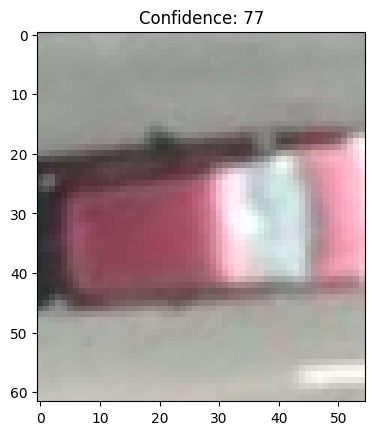

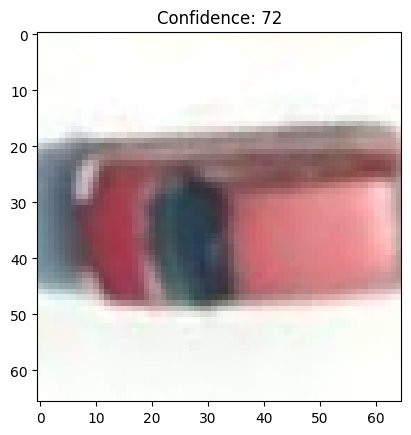

showing rotated image


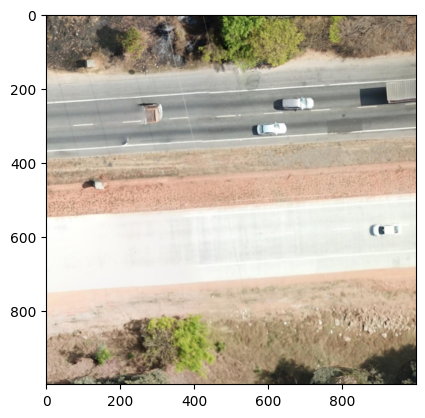

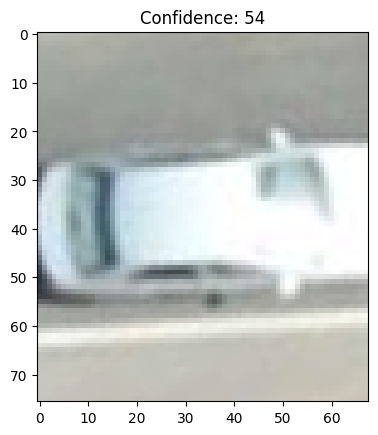

In [9]:
img_layer = ImageProcessingLayer(mock_wait_time=1)
obj_layer = ObjectDetectionLayer()
mav_layer = MavlinkInterfaceLayer()

detections = []

index = 0
for img, img_corner_gps_coords in img_layer.run():
    print("showing rotated image")
    plt.imshow(img)
    plt.show()
    index = index + 1
    if index == 20:
        break
        
    bboxes = obj_layer.run(img)
#     mav_layer.run(bboxes)
    
    detections.append((img_corner_gps_coords, bboxes))
    for bbox in bboxes:
        plt.imshow(img[bbox[0]:bbox[1], bbox[2]:bbox[3]])
        plt.title("Confidence: {}".format(bbox[4]))
        plt.show()

## Bounding box corner coordinate conversion

In [11]:
bb_corner_gps_coords_list = []
sample_corner_gps_coords_list = []

for detection in detections:
    sample_corner_gps_coords = detection[0]
    width = OUTPUT_DIM[1]
    height = OUTPUT_DIM[0]

    sample_pixel_to_gps_transform = get_pixel_to_gps_transform(sample_corner_gps_coords, width, height)
    sample_bb_corner_gps_coords_list = []
    for bb_pixel_coords in detection[1]:
        top_left_corner_pixel = (bb_pixel_coords[2], bb_pixel_coords[0])
        top_right_corner_pixel = (bb_pixel_coords[3], bb_pixel_coords[0])
        bot_left_corner_pixel = (bb_pixel_coords[2], bb_pixel_coords[1])
        bot_right_corner_pixel = (bb_pixel_coords[3], bb_pixel_coords[1])

        top_left_corner_gps = sample_pixel_to_gps_transform(top_left_corner_pixel)
        top_right_corner_gps = sample_pixel_to_gps_transform(top_right_corner_pixel)
        bot_left_corner_gps = sample_pixel_to_gps_transform(bot_left_corner_pixel)
        bot_right_corner_gps = sample_pixel_to_gps_transform(bot_right_corner_pixel)

        coords = top_left_corner_gps, top_right_corner_gps, bot_left_corner_gps, bot_right_corner_gps
        sample_bb_corner_gps_coords_list.append(coords)
    bb_corner_gps_coords_list.extend(sample_bb_corner_gps_coords_list)
    sample_corner_gps_coords_list.append(sample_corner_gps_coords)


In [12]:
# Print GPS coordinates of corners of each bounding box
for corner_gps_coords in bb_corner_gps_coords_list:
    for coord in corner_gps_coords:
        print(f"({coord[0]:0.5f}, {coord[1]:0.5f})", end=', ')
    print()

(12.86133, 77.51922), (12.86133, 77.51926), (12.86129, 77.51922), (12.86129, 77.51926), 
(12.86075, 77.52062), (12.86073, 77.52065), (12.86072, 77.52061), (12.86071, 77.52064), 
(12.86075, 77.52063), (12.86073, 77.52065), (12.86072, 77.52061), (12.86071, 77.52064), 
(12.86056, 77.52066), (12.86054, 77.52069), (12.86053, 77.52064), (12.86051, 77.52067), 
(12.86053, 77.52106), (12.86051, 77.52109), (12.86049, 77.52104), (12.86048, 77.52107), 


# Smopy Visualization

In [13]:
import smopy

In [14]:
base_coordinates = np.array(DATASET_CORNER_GPS_COORDS)

min_lat = min(base_coordinates[:,0])
max_lat = max(base_coordinates[:,0])
min_lon = min(base_coordinates[:,1])
max_lon = max(base_coordinates[:,1])

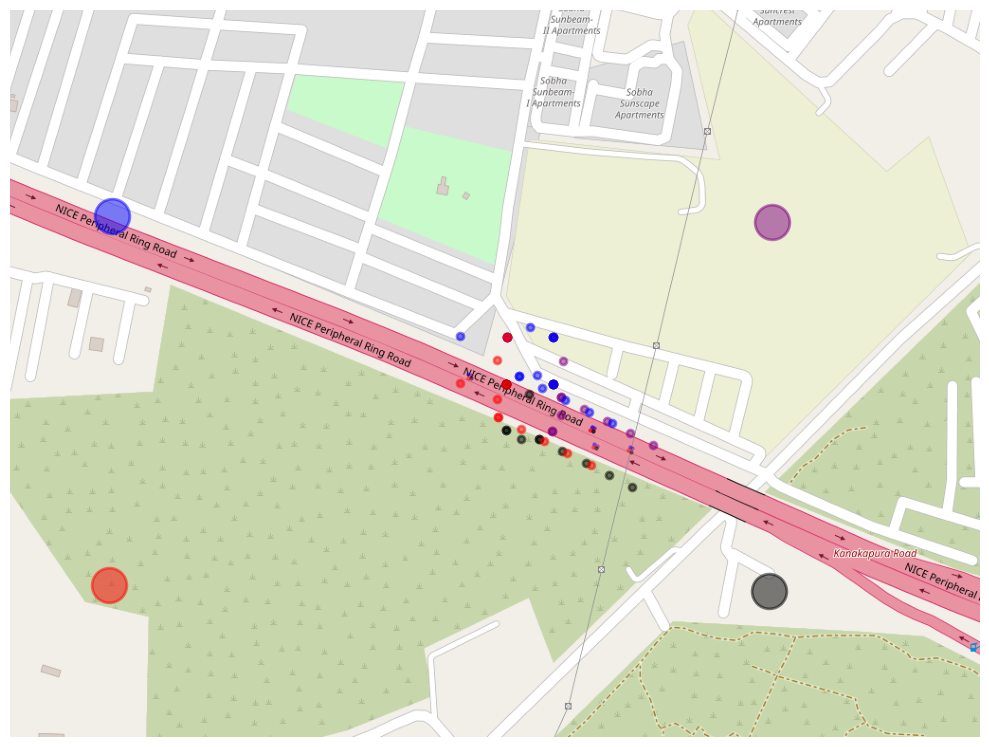

In [16]:
map = smopy.Map((min_lat,min_lon,max_lat,max_lon), z=17)
ax = map.show_mpl(figsize=(10, 10))

# [top left, top right, bottom left, bottom right]
corner_colors = ["blue", "purple", "red", "black"]

# Print dataset corners
for index, dataset_corner_gps in enumerate(DATASET_CORNER_GPS_COORDS):
    dataset_corner_gps = (dataset_corner_gps[0], dataset_corner_gps[1])
    x, y = map.to_pixels(dataset_corner_gps)
    ax.plot(x, y, 'o', ms=25, mew=2, alpha=0.5, color=corner_colors[index]);
    
# Print corners of each sample image
for sample_corner_gps_coords in sample_corner_gps_coords_list:
    for index, sample_corner_gps in enumerate(sample_corner_gps_coords):
        sample_corner_gps = (sample_corner_gps[0], sample_corner_gps[1])
        x, y = map.to_pixels(sample_corner_gps)
        ax.plot(x, y, 'o', ms=5, mew=2, alpha=0.5, color=corner_colors[index]);
    
# Print corners of each bounding box
for bb_corner_gps_coords in bb_corner_gps_coords_list:
    for index, bb_corner_gps in enumerate(bb_corner_gps_coords):
        bb_corner_gps = (bb_corner_gps[0], bb_corner_gps[1])
        x, y = map.to_pixels(bb_corner_gps)
        ax.plot(x, y, 'o', ms=1, mew=2, alpha=0.5, color=corner_colors[index]);